## Import modules

In [1]:
# !pip install Dask

In [2]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import os
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from glob import glob
# import dask
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

In [3]:
# import dask.dataframe as dd
# from dask.distributed import Client

In [4]:
# from dask.distributed import Client, LocalCluster

## Load in features

In [5]:
ROOT = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T20_11_Lille1_1_cylinder_r_0_1414_grid_0_0283_features.npz"""
ROOT2 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T22_37_Lille1_1_cylinder_r_0_2828_grid_0_0566_features.npz"""
ROOT3 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T23_42_Lille1_1_cylinder_r_0_5657_grid_0_1131_features.npz"""
ROOT4 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_30T00_21_Lille1_1_cylinder_r_1_1314_grid_0_2263_features.npz"""
ROOT5 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_30T05_07_Lille1_1_cylinder_r_2_2627_grid_0_4525_features.npz"""
ROOT6 = """/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/2025_11_29T19_09_Lille1_1_cylinder_r_4_5255_grid_0_9051_features.npz"""

In [6]:
fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5, ROOT6]
# fileList = [ROOT,ROOT2, ROOT3,ROOT4,ROOT5]

## Get computed features

In [7]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

# lastFi = np.load(fileList[-1], allow_pickle=True)["array2"]

# das = np.hstack((das, lastFi))

# xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

In [8]:
# del lastFi
gc.collect()

113

## Load in points and labels

## Combine road markings with Ground points

In [9]:
# cls[cls==2] = 1

In [10]:
# cls[cls > 1] -= 1

## Get columns

In [11]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","HeightVariance","HeightRange","count"]

In [12]:
len(cols)

12

In [13]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [14]:
allCols = ff + ['label']

In [15]:
allAtrs = np.hstack((das, cls.reshape(-1, 1)))

In [16]:
del das, cls

## Create dataframe

In [17]:
allAtrs.shape

(30033430, 73)

In [18]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

    
# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [23]:
total_dataframe.to_parquet("""/home/sspiegel/CapstoneData/Paris/training_10_classes/pickleFiles/cylinder/training/total_training.parquet""", engine='fastparquet')

In [19]:
total_dataframe = dd.from_pandas(total_dataframe, npartitions=100000)

In [20]:
gc.collect()

234

In [24]:
client = Client()

In [25]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 94.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36683,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:34805,Total threads: 4
Dashboard: http://127.0.0.1:43463/status,Memory: 11.79 GiB
Nanny: tcp://127.0.0.1:42329,


In [26]:
rf = RandomForestClassifier(verbose = -1)

In [27]:
import joblib

In [54]:
# with joblib.parallel_backend('dask'):
#     pass

In [28]:
from sklearn.model_selection import GridSearchCV

grid = {"n_estimators" : [50,100],"max_depth" : [30,50]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid, n_jobs=-1)

In [29]:
RemainTestX = total_dataframe[ff]
RemainTestY = total_dataframe["label"]

In [30]:
gc.collect()

166

In [31]:
# total_dataframe

In [ ]:
with joblib.parallel_backend('dask'):
    grid_search.fit(RemainTestX, RemainTestY)

/home/sspiegel/miniconda3/envs/masterEnv/lib/python3.12/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 16.34 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [55]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

# RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = total_dataframe.loc[total_dataframe["label"] == i]
        if SelectList.shape[0] == 0:
            continue
        # SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState, replace = True)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
    with joblib.parallel_backend('dask'):    
        rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = total_dataframe[ff]
    RemainTestY = total_dataframe["label"]
    
    total_dataframe = total_dataframe.loc[~total_dataframe["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = total_dataframe.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   


Starting iteration 1...
Label 1


TypeError: Trying to convert <dask_expr.expr.Scalar: expr=(Loc(frame=df, iindexer=df['label'] == 1)).size() // 73 == 0, dtype=bool> to a boolean value. Because Dask objects are lazily evaluated, they cannot be converted to a boolean value or used in boolean conditions like if statements. Try calling .compute() to force computation prior to converting to a boolean value or using in a conditional statement.

In [25]:
# del allAtrs

In [26]:
gc.collect()

0

In [27]:
# total_dataframe.max()

In [21]:
# ss = ss[ss["count"] > 10]

In [22]:
# total_dataframe.head()

## Create PLY files with features (Only do if they don't already exist)

In [23]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [24]:
# total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
# total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [26]:
# !pip install "dask[distributed]" --upgrade 

In [28]:
from dask.distributed import LocalCluster

In [25]:
# total_dataframe.head()

In [26]:
# total_dataframe.groupby("label").size() / total_dataframe.shape[0]

In [29]:
# !pip install dask-ml

In [30]:
joblib

<module 'joblib' from '/home/sspiegel/miniconda3/envs/masterEnv/lib/python3.12/site-packages/joblib/__init__.py'>

In [29]:
total_dataframe.shape

(<dask_expr.expr.Scalar: expr=df.size() // 73, dtype=int64>, 73)

In [30]:
param_grid = {"n_estimators" : [50, 75, 100],"max_depth" : [10,20,30,40]}

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
from dask.distributed import Client, progress

In [45]:
client = Client(processes = False, threads_per_worker = 5, memory_limit = '10GB')

2025-11-30 09:31:08,221 - distributed.worker.memory - WARNING - Worker is at 533% memory usage. Pausing worker.  Process memory: 49.67 GiB -- Worker memory limit: 9.31 GiB
2025-11-30 09:31:08,223 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 49.67 GiB -- Worker memory limit: 9.31 GiB


In [46]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.50.47:8787/status,
Dashboard: http://192.168.50.47:8787/status,Workers: 1
Total threads: 5,Total memory: 9.31 GiB
Status: running,Using processes: False
Comm: inproc://192.168.50.47/5488/9,Workers: 0
Dashboard: http://192.168.50.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://192.168.50.47/5488/12,Total threads: 5
Dashboard: http://192.168.50.47:33289/status,Memory: 9.31 GiB
Nanny: None,


In [34]:
client.close()

In [39]:
total_dataframe.shape

(<dask_expr.expr.Scalar: expr=df.size() // 73, dtype=int64>, 73)

In [44]:
total_dataframe.memory_usage_per_partition()

Dask Series Structure:
npartitions=100
    int64
      ...
    ...  
      ...
      ...
Dask Name: operation, 2 expressions
Expr=MemoryUsagePerPartition(frame=df)

In [41]:
print(memory_per_partition)

Dask Series Structure:
npartitions=100
    int64
      ...
    ...  
      ...
      ...
Dask Name: operation, 2 expressions
Expr=MemoryUsagePerPartition(frame=df, deep=True)


In [25]:
rf = RandomForestClassifier(verbose=1, n_estimators=50,n_jobs=8)

In [26]:
rf

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
total_dataframe.reset_index(inplace = True)

In [28]:
# total_dataframe.head()

In [29]:
gc.collect()

404

In [ ]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

# RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,10):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = total_dataframe.loc[total_dataframe["label"] == i]
        if SelectList.shape[0] == 0:
            continue
        # SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState, replace = True)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = total_dataframe[ff]
    RemainTestY = total_dataframe["label"]
    
    total_dataframe = total_dataframe.loc[~total_dataframe["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = total_dataframe.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8
Label 9


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


In [ ]:
gc.collect()

SelectList.shape

## Plot iterations and accuracy

In [29]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

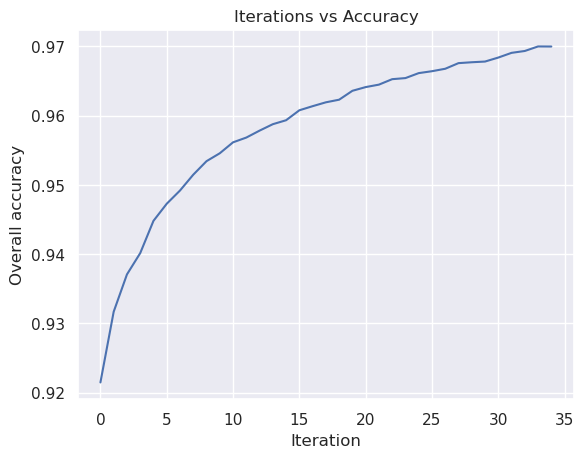

In [30]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [32]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_cylinder_RF_Lille.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_15_Trained_cylinder_RF_Lille.joblib']